___
![Low dimentional Representation of Selected Data Input Columns](./pics/tsne_test.png)

**Christmas in July or a low dimenational representation of selected columns from the input data?**
___

# Senseye ML Challenge
This notebook contains my answer to the Senseye ML Challenge. It is ment not so much as a contest type answer (get the highest score to the 4th decimal place etc...) but as a demonstration of my problem solving process and some actually implementable things I think Senseye could benifit from when working on problems like this at scale. Along the way, I want to demonstrate a couple of plug-and-play extras:

1. Scalable data structures and parallel processing through delayed compute task graphs:
    Senseye could benefit from these data structures because they streamline research and modeling on large data from disparate sources without lots of time, effort, and money spent on big fancy data storage infrastructure.
    
2. Large-scale visualizations capable of plotting billions of points:
    When solving hard problems like those Senseye faces, only plotting sub-samples may not be enough. To reveal the strucutre of very large data sets, it may be nessesary to plot billions of observations and many features on one plot.

# Goal 
The stated goal of this challenge is **to generate a predictor for cognitive difficulty from eye motion data**. Also, I would like to understand a bit of what's going on in the data as well, try finish the process with a fully scalable method that increases understanding as well as generates decent predictions and can inform decisions for others invovled in building these products. 

So I will explore the problem and data space, use visualization tools to help increase my understanding of the situation, try to find some patterns in the data visually or manually, train a predictor and test its performance. I also want to keep in mind this process will likely have to be scaled to large, out-of-memory data sets, likely wihtout a lot of "big data" type storage structure ready to use. 

# Overview
Briefly, I investigated the background of such a problem. 

I skimmed over some previous work with some similarities, and watched some product videos for something similar (an eye tracker called tobii) to try to get by bearings for starters:

[source 1] https://arxiv.org/pdf/1409.1484.pdf

[source 2] https://arxiv.org/pdf/1805.07253.pdf

[source 3] https://www.youtube.com/watch?time_continue=19&v=hTKy0dps8X0


___

The meta data given with the challenge is as follows:
___
Each row represents a 5 second window of time during a question & answer period.  Thus multiple slices are available for each question_number.

**'participant_number'** - Participants in this study were numbered to uniquely identify them

**'difficulty'** - the value we're interested in predicting

**'question_number'** - each participant is given several different questions

**'duration'** - how long each bow event lasts

**'count'** - number of bow events in a given window

**'frequency'**  - rate of bow events

**'magnitude'** - bow magnitude
___

Ok, so I will be fitting features extracted from observing eye movements to a measure of cognitive difficulty based on an experiment run with a nubmer of different questions and test subjects (people). Although the question and participants will help make representative samples, I don't think they should be included in a model which is designed to generalize to other problems and people. So, those will be left out of the model building. Overall, it looks like this is a well formed enough problem and problems with some similarities are being worked on out there. So, I think this is a "proceed". 
 
The notebook is organized as follows:

    * Load Libraries
    * Load Data
        - Parrallel data processing and scalability
        - Initial Thoughts on the Data
    * Scalable visualization
    * Further Visualization
    * Data review and working on the features
    * Data Cleaning
    * Modeling
        - Balancing Classes
        - Training
        - Performance and Interpretation
    * Conclusion

# Load Libraries
I will use a number of 3rd party libraries in this notebook. It is possible that lots of libraries make the code less stable, but I think these are worth it, epecially for working with an early-stage problem. I will also load some libraries as I go, I usually wouldn't do this, but it helps for the sake of clarity with a long notebook like this. 

In [623]:
from dask.distributed import Client, progress
import dask.dataframe as dd
import dask.array as da
from dask.distributed import progress
#import distributed

import numpy as np

import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf
from datashader.utils import export_image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the data 
Next, I'll read in the data. I will use the dask dataframe dat astructure, not becuse its needed in this case, but to demonstrate a scalable structure that Senseye could plug into a much bigger collection of data. Using dask dataframe, I could do this same work including the visualization on TB scale, out-of-memory data.

In [4]:
# launch a dask cluster, on my very humble machine. 
client = Client()

In [5]:
client

Client Scheduler: tcp://127.0.0.1:34887 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 16.69 GB


In [106]:
# now, I'll read in the csv as a dask dataframe (see the '*', it could be a group of many files)
sens = dd.read_csv('/home/andrewrs/Desktop/github/senseye/ml_code_challenge/*.csv', header = 0, sep= ',') 

In [9]:
# take a look: Looks like a dataframe....
sens.head()

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude
0,104,3.0,0.0,0.000,0.0,0.000000,8,77
1,105,3.0,0.0,0.000,0.0,0.000000,8,77
2,106,3.0,3.0,0.112,1.0,8.928571,8,31
3,107,3.0,3.0,0.112,1.0,8.928571,8,43
4,108,3.0,3.0,0.112,1.0,8.928571,8,61


## Parrallel data processing and scalability
Here, I take a quick look at the task graph strucutre that defines the dataframe. This is lazy compute, so, if I run a method on the dataframe, it will just build another graph. I have to tell it to "compute" to run. This allows me to build big graph algoriths, then compute them in parallel. 

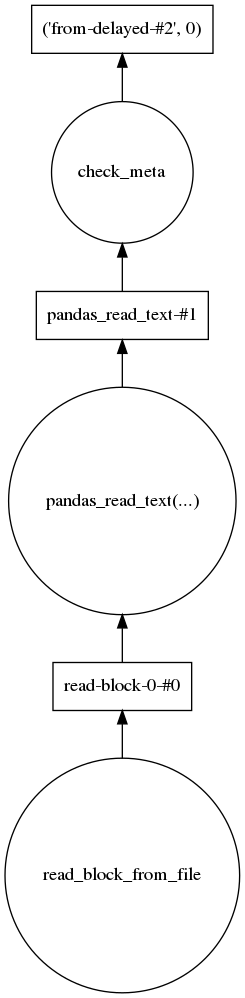

In [11]:
# Take a look at the single file dataframe task graph
sens.visualize()

In [12]:
# I want to look at a summary of the dataframe, so I write: 
desc = sens.describe()

So, it seems like nothing happens. But, I can see the task graph that was just built by dask that is capable of describing a much larger dataframe from many separate files if nessesary, and will compute jobs in parallel, but it will wait to do so until I tell it to with the compute method. This type of data strucutre can be a huge help when the data gets big and there isn't a team of data engineers to build you a beautiful massive data base and custom APIs and dashboards and things to use.  

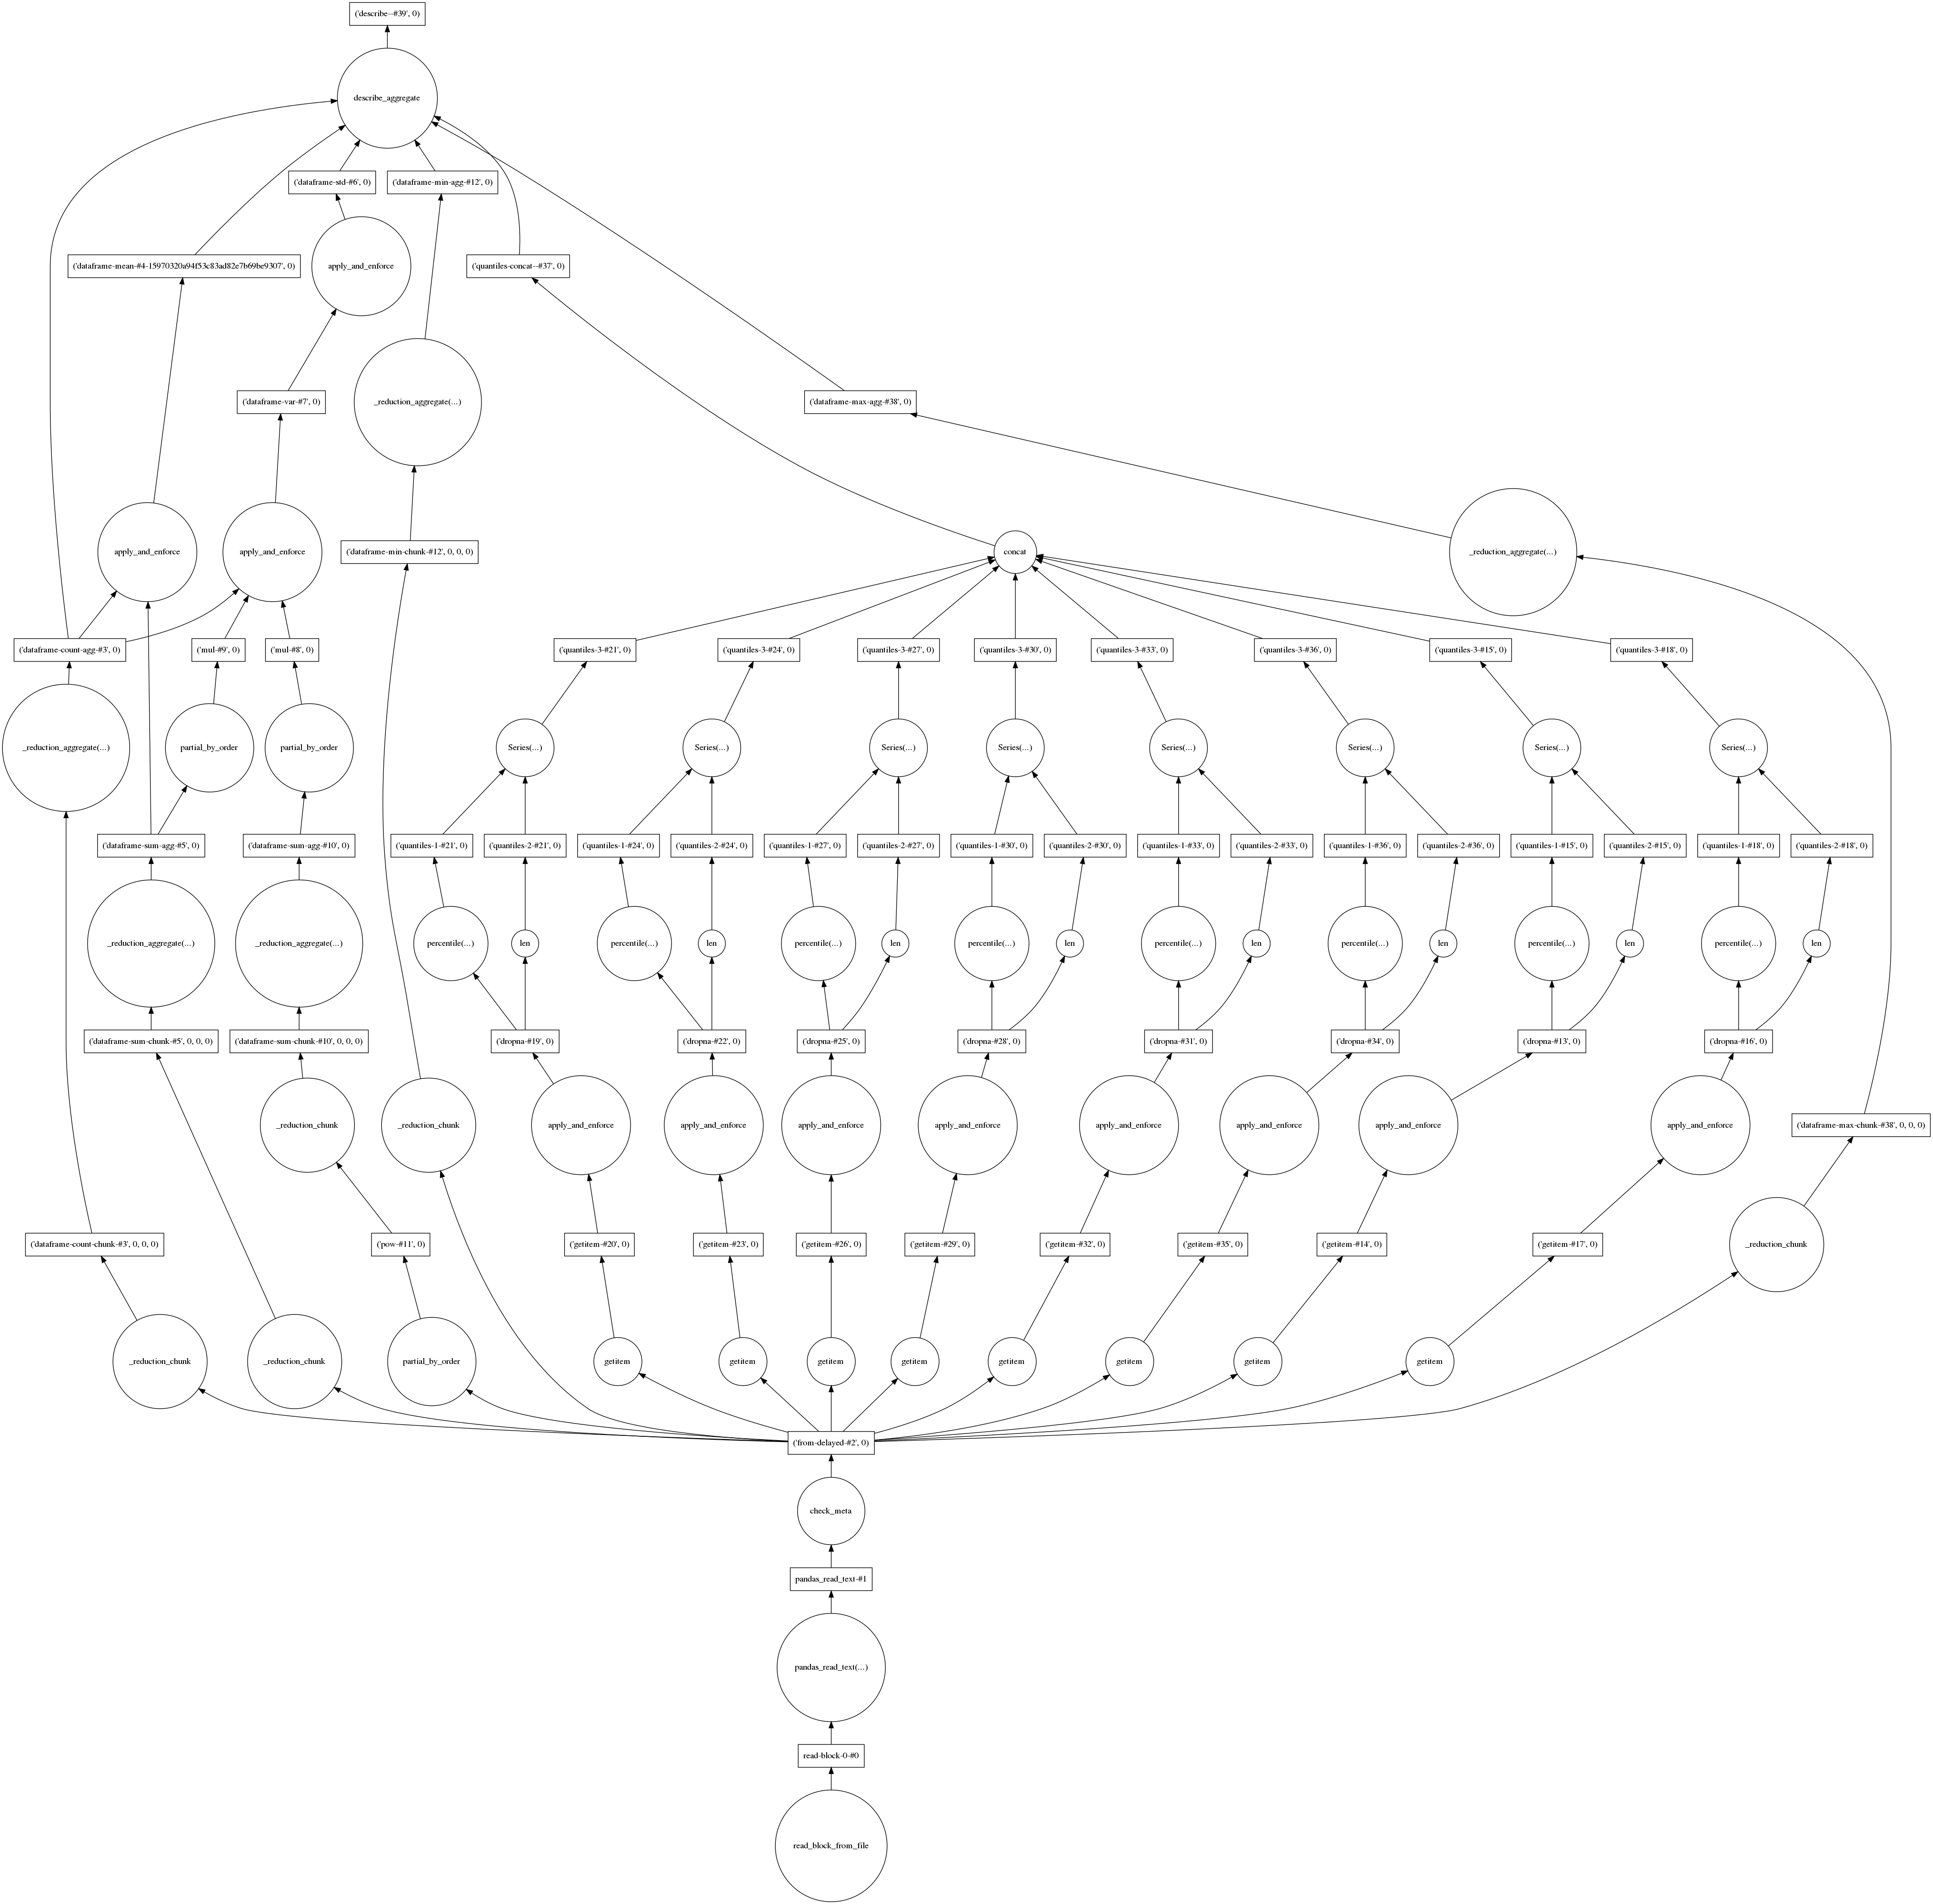

In [13]:
# take a look at it: 
desc.visualize()

In [14]:
# Compute it: 
# Now, I'm running every task outlined in the graph above. This takes a minute. 
desc.compute()

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude
count,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000
mean,21455.669125,11.740167,36.633972,0.155254,2.118240,16.551196,5.370206,50.060472
std,15810.485635,4.209955,19.608587,0.187335,1.383108,15.160438,1.892908,28.441612
min,104.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3218.750000,9.000000,17.000000,0.096000,1.000000,6.756757,4.000000,26.000000
50%,31790.500000,13.000000,34.000000,0.127333,2.000000,14.106583,5.000000,50.000000
75%,34497.250000,15.000000,56.000000,0.166750,3.000000,23.809524,7.000000,75.000000
max,37150.000000,17.000000,67.000000,3.016000,8.000000,500.000000,8.000000,99.000000


In [481]:
# Also, the first few rows (doesn't need compute because a limited number of rows are stored with the object). 
sens.head(10)

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude
0,104,3.0,0.0,0.0000,0.0,0.000000,8,77
1,105,3.0,0.0,0.0000,0.0,0.000000,8,77
2,106,3.0,3.0,0.1120,1.0,8.928571,8,31
3,107,3.0,3.0,0.1120,1.0,8.928571,8,43
4,108,3.0,3.0,0.1120,1.0,8.928571,8,61
5,109,3.0,3.0,0.1480,3.0,20.270270,8,62
6,110,4.0,4.0,0.1248,5.0,40.064103,8,86
7,111,4.0,4.0,0.1280,4.0,31.250000,8,22
8,112,4.0,4.0,0.1228,5.0,40.716612,8,32
9,113,4.0,4.0,0.1228,5.0,40.716612,8,83


## Initial Thoughts on the Data
Now that some of the engineering is taken care of, I can go back to the science a bit. There are already a couple of things: There are effectlively a bunch of tiny little time series in here for each unique participant and question. I might exploit this sturcture, but I'm not entirely sure yet. Also, right up top, I see three of the major categories defining the events "0" but the magnitude has a value, this is something to pay attention to.

# Scalable visualization
At this point in the problem solving process, I would usually try to get a "big - picutre" look at the data. Also, since we want to use this model to make predictions later, (not just on a hold out set from this round of experiments, but generalize to other questions and people) I'm thinking to not include participant, or the question in the model fitting, but I should use them to make good samples of the data later. Thus, in this notebook, I will only use a few feautres, but the process I'm demonstrating here takes into account there could be billions of obervations of thousands of features. 

In [29]:
# For a "flat" view, lets do a dimentionality reduction t-tailed stochastic nearest neighbors is a famous one 
#  in the machine learning world right now, visualization being its main use. 
from sklearn.manifold import TSNE

In [183]:
# take a subset of the data, 
sens_sub = sens[['duration', 'count', 'frequency', 'magnitude']]

# perplexity should be between 5 and 50 usually. 1000 is just a go-for-it thing
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
# Here we are deviating from the distributed method, we would
low_dim = tsne.fit_transform(sens_sub.values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4068 samples in 0.003s...
[t-SNE] Computed neighbors for 4068 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4068
[t-SNE] Computed conditional probabilities for sample 2000 / 4068
[t-SNE] Computed conditional probabilities for sample 3000 / 4068
[t-SNE] Computed conditional probabilities for sample 4000 / 4068
[t-SNE] Computed conditional probabilities for sample 4068 / 4068
[t-SNE] Mean sigma: 2.200732
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.877995
[t-SNE] Error after 1000 iterations: 0.615896


In [421]:
# Just for this demo, I'll compute and persist the frames to make everything easy, they are plenty of 
#  ways around this for bigger data. 
#low_dim[:,2] = sens['Unnamed: 0']
load = dd.from_dask_array(da.from_array(low_dim, chunks = 1000000))
load = load.persist().compute()
sensp = sens.persist().compute()
# align indcies, I know they are still in the right orde
load['difficulty'] = sensp['difficulty']

In [185]:
load.columns = ['d1', 'd2', 'difficulty']
load['difficulty'] = load['difficulty'].astype('category')

# now missing the cat column as describe is only for numeric types
load.describe()

,d1,d2
count,4068.000000,4068.000000
mean,0.351535,1.347432
std,23.611919,41.075191
min,-46.755001,-71.835938
25%,-19.060783,-30.099804
50%,-2.108572,-1.738288
75%,18.183643,35.396985
max,51.474792,74.216469


In [314]:
# Now I'll get datashader going ...

# make a few categories for increasing cognitive load (im cheating a bit here using three meta categories)
color_key = {0.0:'aqua', 1.0:'aqua', 2.0:'aqua', 3.0:'aqua', 4.0:'aqua', 5.0:'aqua', 6.0:'aqua', 7.0:'red', 8.0:'red', 9.0:'red', 10.0:'red', 11.0:'red', 12.0:'red', 13.0:'lime', 14.0:'lime', 15.0:'lime', 16.0:'lime', 17.0:'lime'}

def create_image(df, x_range, y_range, w, h, cmap):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range = x_range, y_range = y_range)
    agg = cvs.points(df, 'd1', 'd2', ds.count_cat('difficulty'))
    shade = tf.shade(agg, color_key = color_key, how='eq_hist')
    # increase point size here...
    return tf.dynspread(shade, threshold=0.8, max_px=50)


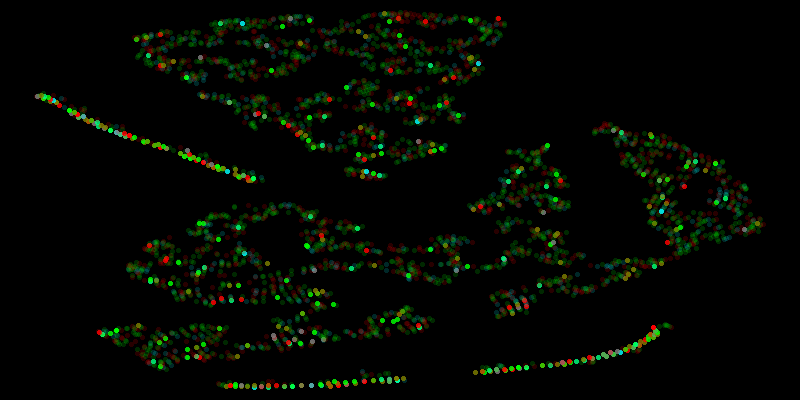

In [320]:
# create the image as an object
d1_im = create_image(load, (load['d1'].min() - 5, load['d1'].max() + 5), (load['d2'].min() - 5, load['d2'].max() + 5), 800, 400, cmap = hot)
# plot the image out
export_image(tf.set_background(d1_im, 'black'),'pics/tsne_test')

Looks like someone had a bad day hanging christmas lights! Although some obvious shapes exists (the three distict shape groups in space, and the 3 lines jump out pretty quickly) it shows there isn't nessesarily a lot of obvious structure relating back to the cognitive difficulty that is emerging out of these 4,000 or so points. If there was, we would see groups of colors. Not nessesarily surprising, but if we had more data, lots more, we may be able to see evidence of some relationships and know that there is structure we can expoit in our models, working towards more generalizable products. Maybe this structure is related to some other variables, but I'm moving on. The framework for plotting I've shown here can be scaled to plot billions of points and a lot more features. 

# Further Visualization
I will do a few more plots before setting up the data for problem solving. These plots are limited to in-memory data, so if a large data set was being used, I would have to sub-sample for this part. 

In [322]:
from ggplot import *

/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [331]:
# Take a look at the data again to refresh my memory 
sensp.head()

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude
0,104,3.0,0.0,0.000,0.0,0.000000,8,77
1,105,3.0,0.0,0.000,0.0,0.000000,8,77
2,106,3.0,3.0,0.112,1.0,8.928571,8,31
3,107,3.0,3.0,0.112,1.0,8.928571,8,43
4,108,3.0,3.0,0.112,1.0,8.928571,8,61


In [425]:
# Set a few column types. 
sensp['participant_number'] = sensp['participant_number'].astype('category')
sensp['question_number'] = sensp['question_number'].astype('category')
sensp['difficulty'] = sensp['difficulty'].astype('int')

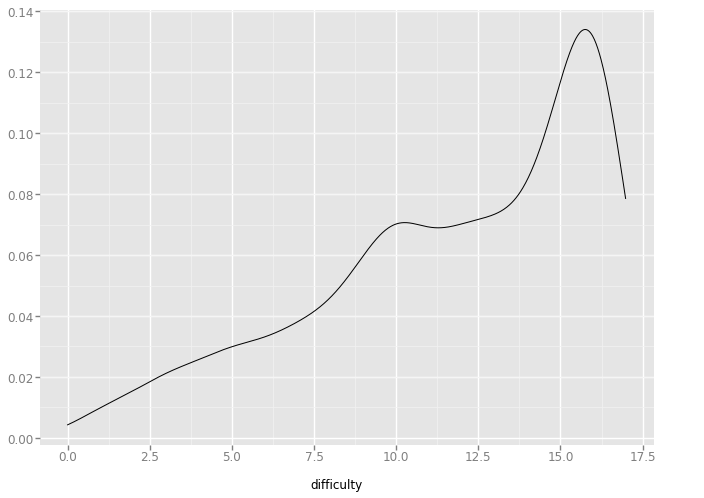

<ggplot: (8757188600966)>

In [351]:
# I first want to look at the distribution of the target variable
p = ggplot(aes(x = 'difficulty'), data = sensp)
p + geom_density()

Looking at the plot above, I can see that there are more examples of difficult problems than easy ones, this can explain some of the lack of structure in the tsne plot, as there are few examples of the easier problems in general. 

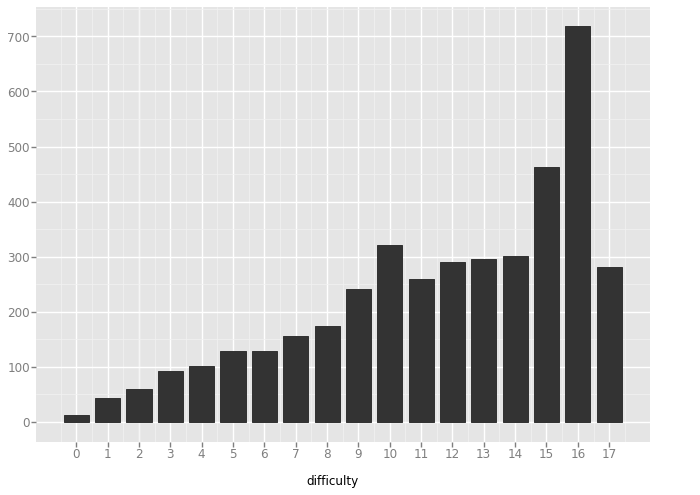

<ggplot: (-9223363279694765894)>

In [363]:
p = ggplot(aes(x = 'difficulty'), data = sensp)
p + geom_bar(stat = 'count')

Above, I'm looking at a lot of 16s, but an increase from 1 to 10, then a sort of plateau with 16 and 15 being visibly higher than the rest. Next, I'll look across the other variables for bias or weirdness or what-have-you. 

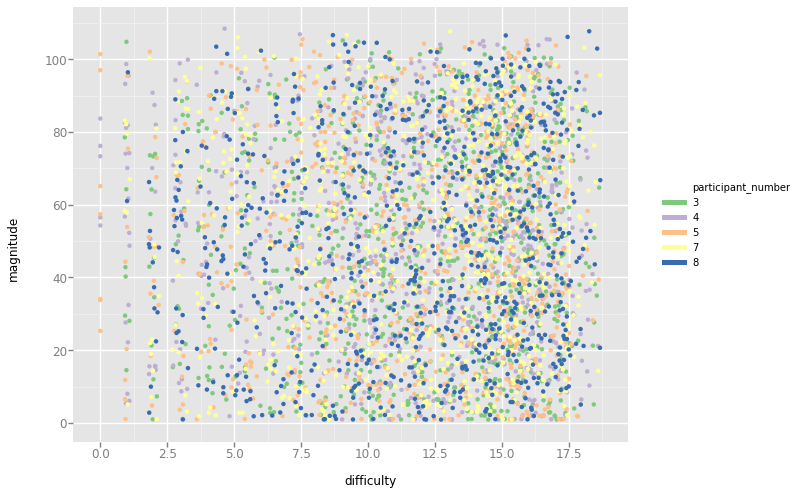

<ggplot: (-9223363279664986992)>

In [341]:
# I'll explore the data some more with ggplot library. I use this library often when I code in R. 
p = ggplot(aes(x = 'difficulty', y = 'magnitude', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

Looking above, it doesn't look like there is a lot of obvious bias in participant number across magnitude and difficulty. 

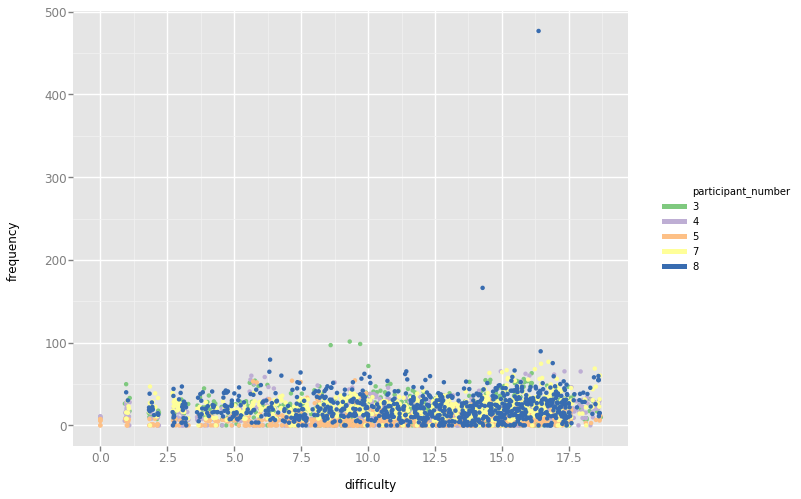

<ggplot: (-9223363279664759401)>

In [427]:
p = ggplot(aes(x = 'difficulty', y = 'frequency', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

With frequency, there are a couple of huge outliers, and the rest on on first glance look similarly represented across the difficulty classes. I will consider removing these outliers though, perhaps frequency threshold of 80 or so. 

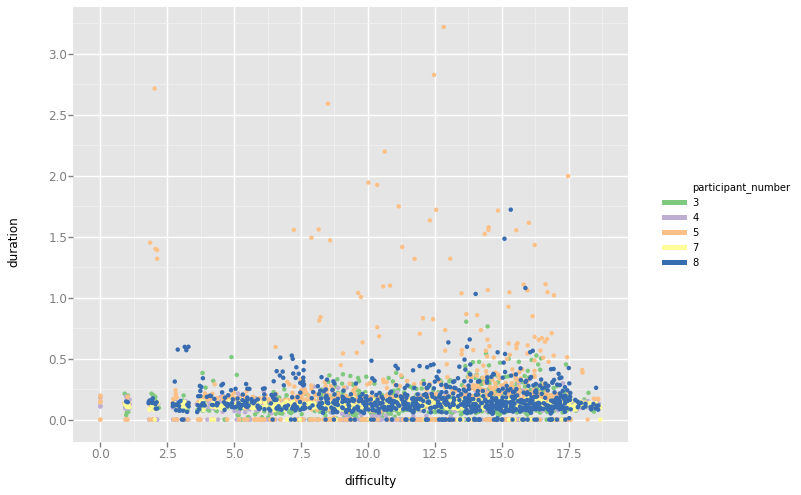

<ggplot: (-9223363279665069189)>

In [343]:
p = ggplot(aes(x = 'difficulty', y = 'duration', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

When looking at duration, I noticed participant 5 seemed to have much longer durations than the others on a number of difficulty levels. It might be worth thresholding the duration as well, or even removing participant 5 altogether. This however, will make a very small data set even smaller. Another issue here is durations of "0", and difficulty of "0". It looks like not all particiapants had a "0" difficulty event. Overall, there may be a slight positive correlation here as well. 

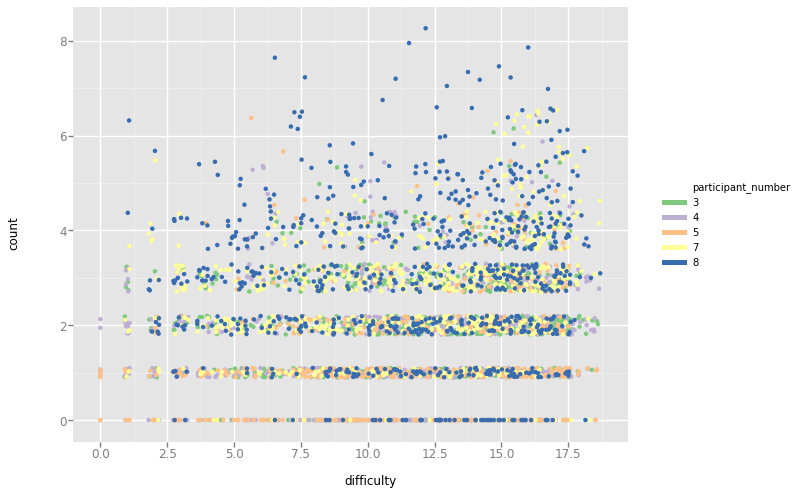

<ggplot: (8757216767741)>

In [368]:
p = ggplot(aes(x = 'difficulty', y = 'count', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

Above, we can see count is distributed across difficulty in a resonable seeming manner. Also, it could exibit a bit a a positive relationship.  

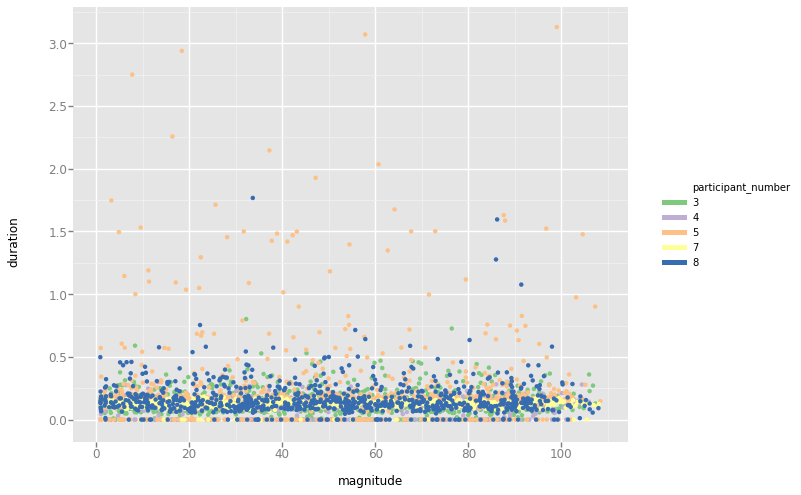

<ggplot: (-9223363279638673148)>

In [376]:
p = ggplot(aes(x = 'magnitude', y = 'duration', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

Above, I did one check with two dependent variables. Not much correlation, and it seems the "0" duration exists all across the magnitudes. 

# Data review and working on the features
The mini time series structure of this data is interesting. If the bow event holds through the 5 second window, then there is no change, aka, the frequency and duration will be zero, but the magnitude will stay constant. Without considering time, this does not really make a fair representaion of an observation in my oppinion and may cause problems when fitting a model. I'm going to choose to stay away from the time series model in this notebook. So, I'm going to make a few changes to the data to make the "one-shot, one-prediction" style model possible, while still trying to give some time context. 

I think I'll add two features as an example. Knowing that each observation is a 5 second chunk, and each person solves a small number of discrete problems, I can add a column that will denote the "solve time" for the participant and question. Additionally, I will add "elapsed_time" or the time that has elaped since the question began. 

In [449]:
# Write a quick piece of code to calculate the solve time and elapsed time

# get unique person / question tags 
sensp['u_tag'] = sensp['question_number'].astype(str) + '_' + sensp['participant_number'].astype(str)
#sensp['solve_time'] = sensp['duration']

# loop through and fill in the seconds
for uni in sensp['u_tag'].unique():
    length = len(sensp.loc[sensp['u_tag'] == uni])
    fill = np.arange(1, length+1)*5
    sensp.loc[sensp['u_tag'] == uni,'solve_time'] = length*5
    sensp.loc[sensp['u_tag'] == uni,'elapsed_time'] = fill

In [450]:
# check out the new column.
sensp.head()

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude,u_tag,solve_time,elapsed_time
0,104,3,0.0,0.000,0.0,0.000000,8,77,0.0_8,10.0,5.0
1,105,3,0.0,0.000,0.0,0.000000,8,77,0.0_8,10.0,10.0
2,106,3,3.0,0.112,1.0,8.928571,8,31,3.0_8,20.0,5.0
3,107,3,3.0,0.112,1.0,8.928571,8,43,3.0_8,20.0,10.0
4,108,3,3.0,0.112,1.0,8.928571,8,61,3.0_8,20.0,15.0


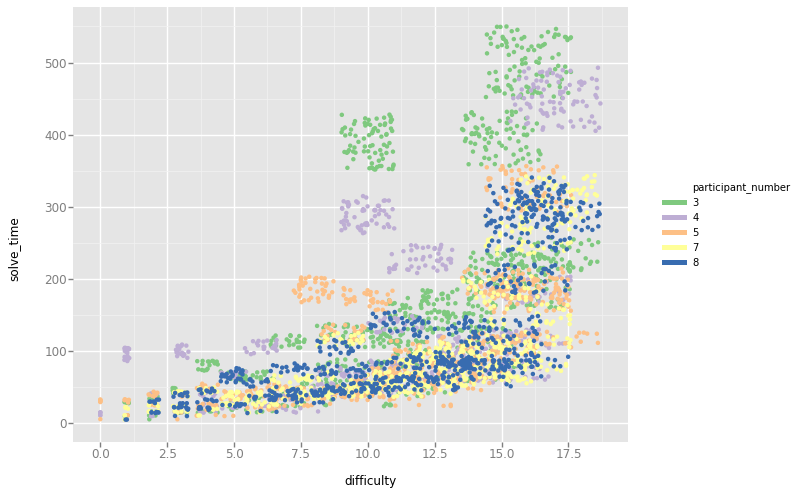

<ggplot: (-9223363279667599244)>

In [451]:
p = ggplot(aes(x = 'difficulty', y = 'solve_time', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

Hey! look at that. Sort of an exponential relationship perhaps. The good news is, this apears to be a worthwhile feature to have made. Additionally, the outlying groups seem to be well explained by participants. 

Although encuraging, this hardly seems like a ground breaking discovery (people spend longer on harder questions), and it introduces some series limitations if this model is is planned to be implemented in "real-time," which Im guessing it is. Adding this feature would limit the model to making predictions retro-actively over unqiue bow events only after the completion of a question. The longest "solve time" is 500 seconds, so in that case, the model wouldn't update for about 8 minutes. Perhaps elapsed time would be better, but again, I'm moving on. 

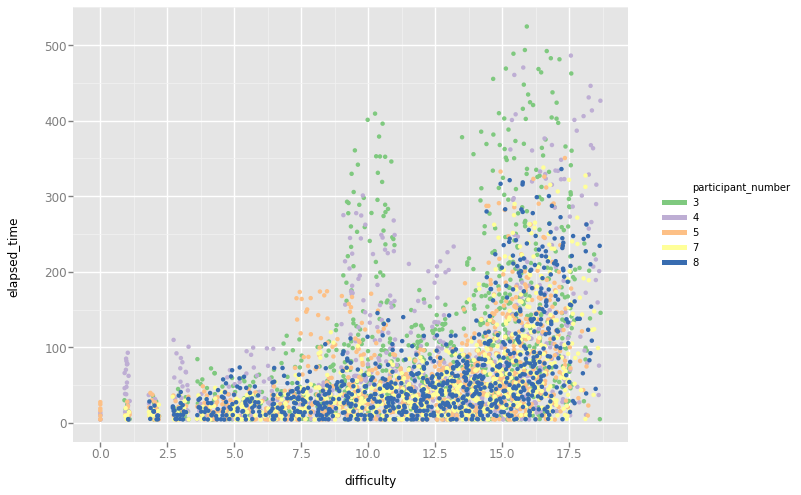

<ggplot: (-9223363279667627951)>

In [452]:
p = ggplot(aes(x = 'difficulty', y = 'elapsed_time', color = 'participant_number'), data = sensp)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

In the above figure, I'm seeing not quite as strong a correlation, but some of the same characteristics (some of the data is exactly the same, those at the end of a question).

# Data Cleaning
After looking at the data set, I'm going to make some sweeping modifications:
1. Threhold the frequency at 100
2. Threshold the duration at 1 
3. Remove Data with zero duration
4. Perhaps most extreme, I will combine some of the lower difficulty categories.

The good news is, I hope to retain some of the information I've cut out by removing the zeros with the solve time feature I added. Combining the categories will lower the resolution of the predictor, but some of the categories have so few examples. Also, I want to demonstrate some "outside the rules" thinking.  

In [453]:
#Make a new dataframe whith the thresholds
sens_clean = sensp.loc[(sensp['duration'] != 0) & (sensp['frequency'] <= 100) & \
                       (sensp['duration'] <= 1),:]

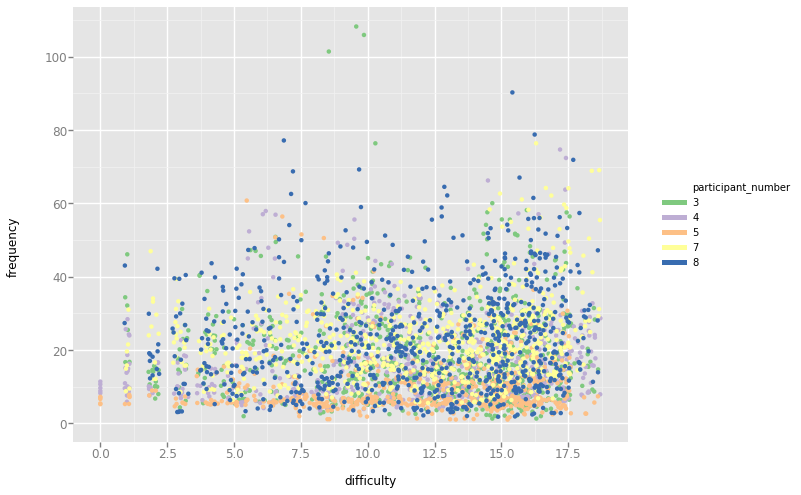

<ggplot: (-9223363279667805268)>

In [454]:
# take a look at it now. 
p = ggplot(aes(x = 'difficulty', y = 'frequency', color = 'participant_number'), data = sens_clean)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

In the above plot, participant 5 remains scattered differently than the rest, this is not ideal, but I think I'll just move on. 

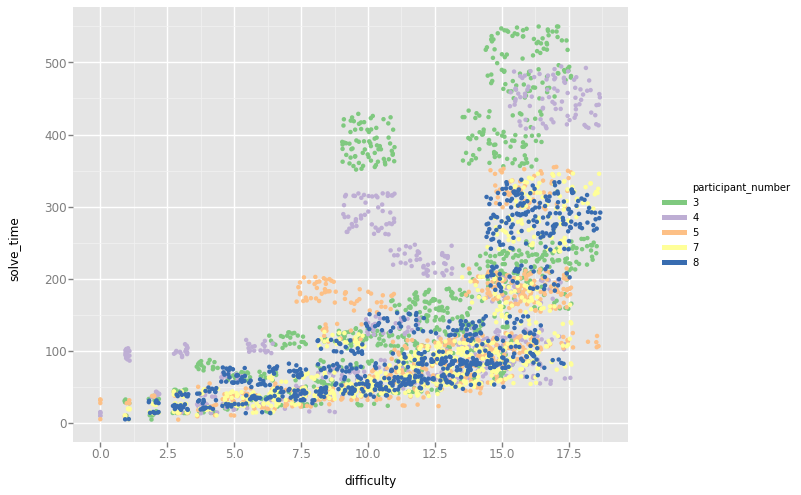

<ggplot: (8757186995155)>

In [455]:
p = ggplot(aes(x = 'difficulty', y = 'solve_time', color = 'participant_number'), data = sens_clean)
p + geom_jitter(jitter = 0.5) + scale_color_brewer(type='qual')

Interesting! In the above plot, I didn't lose chunks after deleting the zeros, but lost instances all over the map so to speak. In my oppinion, this is good, it means we may be able to hold on to some of this time series information. 

In [458]:
# check how many observations were lost
sens_clean.describe()

,Unnamed: 0,difficulty,duration,count,frequency,magnitude,solve_time,elapsed_time
count,3581.000000,3581.000000,3581.000000,3581.000000,3581.000000,3581.000000,3581.000000,3581.000000
mean,20538.032114,11.830215,0.157649,2.389556,18.604964,50.216978,149.209718,77.525831
std,15982.602318,4.212603,0.097857,1.238756,12.187852,28.544655,122.779113,82.958442
min,106.000000,0.000000,0.010000,1.000000,1.052632,1.000000,5.000000,5.000000
25%,3135.000000,9.000000,0.108000,1.000000,9.259259,26.000000,60.000000,20.000000
50%,31649.000000,13.000000,0.133333,2.000000,16.129032,50.000000,105.000000,50.000000
75%,34466.000000,16.000000,0.172000,3.000000,25.316456,75.000000,200.000000,100.000000
max,37149.000000,17.000000,0.983000,8.000000,100.000000,99.000000,500.000000,500.000000


So I've only lost about 500 samples, for now thats fine, I'll move on. Now, I'll combine some classes based on the bar chart. 


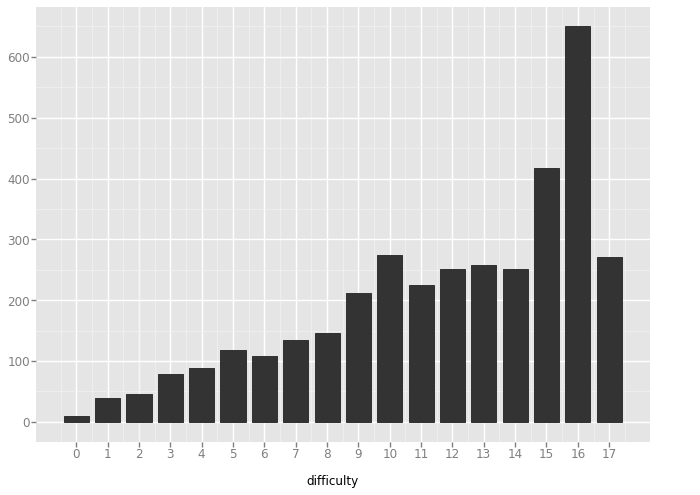

<ggplot: (8757189309753)>

In [473]:
# take a look
p = ggplot(aes(x = 'difficulty'), data = sens_clean)
p + geom_bar(stat = 'count')

In [499]:
# combine class [0, 1, 2, 3, 4], [5, 6], [7,8]
sens_clean['final_class'] = sens_clean['difficulty'].astype(int)

# The lazy way, but, its getting late...
# first
sens_clean.loc[sens_clean['final_class'] == 0,'final_class'] = 0
sens_clean.loc[sens_clean['final_class'] == 1,'final_class'] = 0
sens_clean.loc[sens_clean['final_class'] == 2,'final_class'] = 0
sens_clean.loc[sens_clean['final_class'] == 3,'final_class'] = 0
sens_clean.loc[sens_clean['final_class'] == 4,'final_class'] = 0

# second
sens_clean.loc[sens_clean['final_class'] == 4,'final_class'] = 1
sens_clean.loc[sens_clean['final_class'] == 5,'final_class'] = 1
sens_clean.loc[sens_clean['final_class'] == 6,'final_class'] = 1

# Third
sens_clean.loc[sens_clean['final_class'] == 7,'final_class'] = 2
sens_clean.loc[sens_clean['final_class'] == 8,'final_class'] = 2

/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [500]:
# Take a look at the dataframe
sens_clean.head()

,Unnamed: 0,difficulty,question_number,duration,count,frequency,participant_number,magnitude,u_tag,solve_time,elapsed_time,final_class
2,106,3,3.0,0.1120,1.0,8.928571,8,31,3.0_8,20.0,5.0,0
3,107,3,3.0,0.1120,1.0,8.928571,8,43,3.0_8,20.0,10.0,0
4,108,3,3.0,0.1120,1.0,8.928571,8,61,3.0_8,20.0,15.0,0
5,109,3,3.0,0.1480,3.0,20.270270,8,62,3.0_8,20.0,20.0,0
6,110,4,4.0,0.1248,5.0,40.064103,8,86,4.0_8,20.0,5.0,0


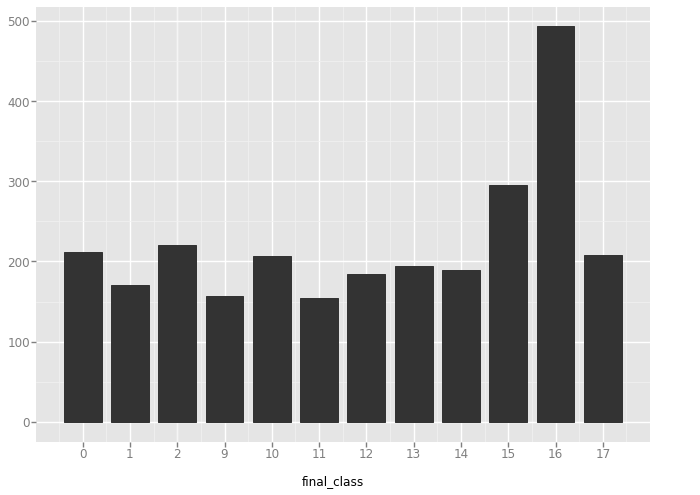

<ggplot: (-9223363279682275703)>

In [508]:
# Import pandas and go with in-memory to finish up. 
import pandas as pd
p = ggplot(aes(x = 'final_class'), data = pd.DataFrame(y_train))
p + geom_bar(stat = 'count')

# Modeling 
Now I finally feel like I have a mental handle on the data enough to get on with the modeling.
Just like usual we need to split into train and test sets. There are many considerations here, I'm going to do this the short way though. 

In [542]:
# Grab the splitter and scaler from sklearn.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Since the data is so small (and I'm running out of time), I just split it up the easy way 
X_train, X_test, y_train, y_test = train_test_split(sens_clean[['duration', 'count', 'frequency','magnitude', 'solve_time', 'elapsed_time']], sens_clean['final_class'])

# fit the scaler on the training data. 
scaler = StandardScaler()
scaler.fit(X_train)

# scale the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


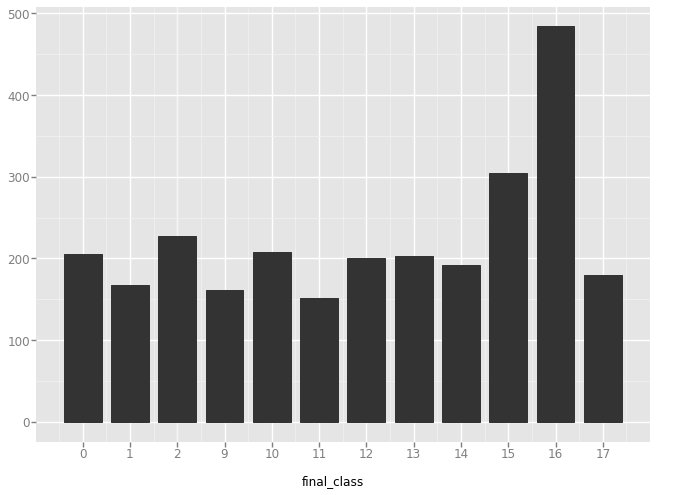

<ggplot: (-9223363279666004115)>

In [543]:
# take a look at the target distributions for train and test
p = ggplot(aes(x = 'final_class'), data = pd.DataFrame(y_train))
p + geom_bar(stat = 'count')

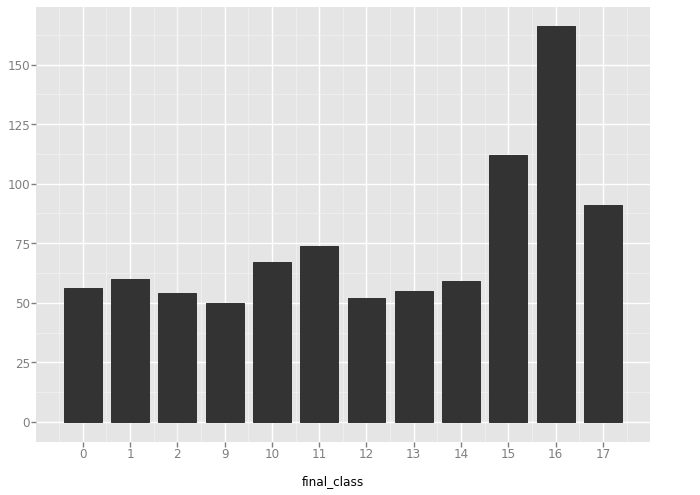

<ggplot: (8757157547454)>

In [544]:
p = ggplot(aes(x = 'final_class'), data = pd.DataFrame(y_test))
p + geom_bar(stat = 'count')

So, the train and test target variable distributions are pretty close, thanks to sklearn.

## Balancing Classes
Usually I would down sample 15 and 16 to get a balanced data set for training, but I'm just going to leave them this time. I might put in a control for it in the model. 

## Training 
I'm jumping right to training a gradient boosted tree classifier. I would usually want to try a few different things in parrallel, including a benchmark, in this case ordinal classification, but its time to wrap this up, so I'm just going to hit it with one basic model as an example. 

In [618]:
# import the gradient boosted tree classifer. 
from xgboost import XGBClassifier as xgb
from xgboost import plot_importance

# get the accuracy score metric 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [612]:
# Define and train the model, using mostly the default features, but deeper trees, smaller
# learning rate, and more estimators,lots more regulation, and changing the sample levels. 
# In my past experience with small data sets, with more classes than features,
# I've found sometimes these hyper parameters do a decent job
model = xgb(base_score=0.5, booster='gbtree', colsample_bylevel=0.92,
       colsample_bytree=0.92, gamma=0, learning_rate=0.0003, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=7000,
       n_jobs=1, nthread=6, objective='multi:softprob', random_state=0,
       reg_alpha=0.9, reg_lambda=0.9, scale_pos_weight=1, seed=1234,
       silent=False, subsample=1)

# subset the data with only the training features
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.92,
       colsample_bytree=0.92, gamma=0, learning_rate=0.0003,
       max_delta_step=0, max_depth=25, min_child_weight=1, missing=None,
       n_estimators=7000, n_jobs=1, nthread=6, objective='multi:softprob',
       random_state=0, reg_alpha=0.9, reg_lambda=0.9, scale_pos_weight=1,
       seed=1234, silent=False, subsample=1)

In [614]:
# Make Predictions
y_pred = model.predict(X_test)

/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Performance and Interpretation
Here, I'll do an elementary test performance, and a little bit of model evaluation. 

In [615]:
# simplistic model performance test
accuracy_score(y_test, y_pred)

0.703125

In [616]:
# Also check the training score
y_pred = model.predict(X_train)
accuracy_score(y_train, y_pred)

/home/andrewrs/anaconda3/envs/dovis/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9307262569832402

70% test accuracy is bad, especially from a 93% training score. This is an overfit model. I'm not here to make the best model right now, but rather to demonstrate what I would do with it. Its worth noting that this is just classification, and doesn't have the added info about order. Next, I'll look at feature importance

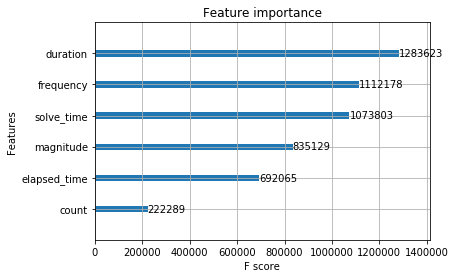

In [619]:
# visualize the most important features
plot_importance(model)

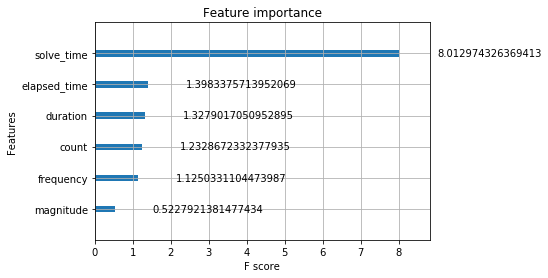

In [622]:
# visualize the most important features
plot_importance(model, importance_type = 'gain')

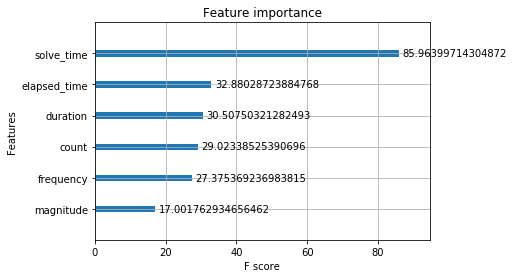

In [621]:
# visualize the most important features
plot_importance(model, importance_type = 'cover')

Looking at the figures above, I can see both elapsed time and solve time were important features. This would lead me to believe finding more features that have to do with the interplay between time and the eye movements would increase the predictive power. 

# Conclusion
Although I did not get the model performance I was hoping for, I do think I was able to bring some important structure into the data which increased the model performance. Additionally, I did not use question number or participant number from the original data set, as fitting with these variables would leave the model useless for predicting general cases. I chose xgboost as a quick example, though implementing models from this library in production software may not be ideal. Furthermore, the addition of the solve time feauture severly limits the real-time speed at which the model could operate, it would have to wait until tasks are completed or problems solved and then back-predict the cognitive load in "finished problem time chunks". 
Feeding input data into this model for live predictions would require all steps performed in the pre-processing here to be performed on the fly. Most of these are reasonable, as they are simple thresholds or scaling operations with previously fit scaling models. However, the solve time and elapse time features would need some method of being added to the input stream live. This may not be possible, or a least must be investigated. 

Specific actions or inportat information stemming from this analysis include:
1. More work on the source data, ideally getting more (data from more participants, for example)
2. More work on the features, heirarchal interactions, colinearity needs to be tested 
3. Model fitting: a bench march, different models and strategies, hyper-parameter tuning
4. More visualization of data structure to gain more insight
5. A pilot model could be tested live to investigate the efficacy of using sove time and/or elapsed time as features 

I find it useful to look back at the big, original picture again after all the analysis dust has settled. In retrospect, I bet the thin lines are the zero-variables where there is no new event but the magnitude stays constant. Getting rid of those and trying to focus on the structure in the rest of the dat seems like it is probably one do-able way of approaching this problem.

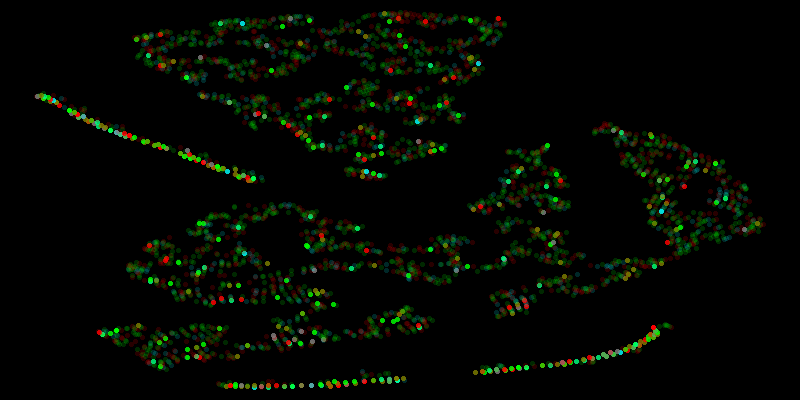

In [624]:
export_image(tf.set_background(d1_im, 'black'),'pics/tsne_test')